In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [3]:
import findspark
findspark.init()

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import lag, col, expr, collect_list, udf, lit, when, avg, row_number
from pyspark.ml.clustering import KMeans

import numpy as np
import matplotlib.pyplot as plt

+----------+------------------+
|prediction|      avg_distance|
+----------+------------------+
|         1| 1775.898088395144|
|         6|1793.3943233106804|
|         3|1689.1893064051264|
|         5|1674.5108219425827|
|         9| 1594.607741287667|
|         4| 1308.124994122389|
|         8|1525.7572806679095|
|         7| 1669.524000443875|
|         2|1712.1066103626426|
|         0|1462.3271595981425|
+----------+------------------+



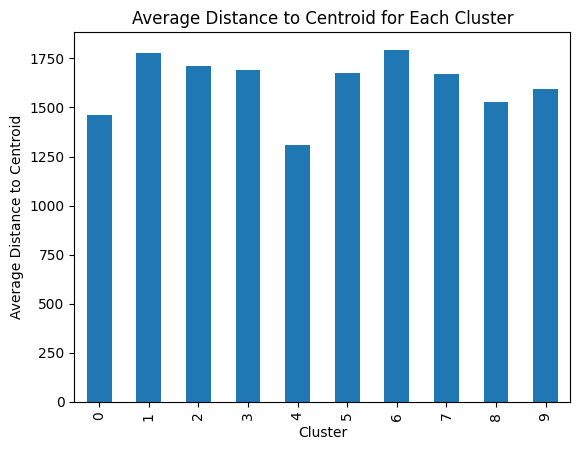

In [15]:
class KMeansClustering:
    def __init__(self,
                 data_path,
                 k=10,
                 weightIds = [0, 1, 2, 3, 4, 7, 8, 11, 18, 61],
                 weightVal = 100):

        self.spark = SparkSession.builder \
                                  .appName("Clustering") \
                                  .getOrCreate()

        self.data_path = data_path
        self.weightIds = weightIds
        self.weightVal = weightVal
        self.k = k

        self.model = None
        self.data = None
        self.cluster_centers = None
        self.avg_distances = None


    def load_data(self):
        data = self.spark.read.csv(self.data_path,
                                   header=False,
                                   inferSchema=True)

        assembler = VectorAssembler(inputCols=data.columns[1:],
                                    outputCol="features")

        data = assembler.transform(data)
        self.data = data.withColumnRenamed(data.columns[0], "label") \
                        .select("label", "features")

    def assign_weights(self):
        weightVal = self.weightVal
        window = Window.orderBy(lit(1))
        weighted_data = self.data.withColumn("row_id", row_number().over(window) - 1)

        weighted_data = weighted_data.withColumn("weight", lit(1))
        for row_index in self.weightIds:
            weighted_data = weighted_data.withColumn("weight",
                when(weighted_data["row_id"] == row_index, lit(weightVal)) \
                .otherwise(weighted_data["weight"]))

        self.data = weighted_data.drop("row_id")

    def kmeans_clustering(self):
        k = self.k
        kmeans = KMeans(k=k, weightCol="weight", seed = 1)
        model = kmeans.fit(self.data)
        self.cluster_centers = model.clusterCenters()
        return model

    def compute_average_distances(self, model):
        predictions = model.transform(self.data)

        # Collect cluster centers to the driver
        cluster_centers = self.cluster_centers

        def euclidean_distance(point, center):
            return float(np.linalg.norm(point - center))

        # Create a UDF for distance calculation
        distance_udf = udf(lambda point, center:
                           euclidean_distance(point, cluster_centers[center]),
                           DoubleType())

        # Compute distances
        distances = predictions.withColumn("distance",
                                           distance_udf("features", "prediction"))

        # Compute average distances per cluster
        average_distances = distances.groupBy("prediction") \
                                      .agg(avg("distance").alias("avg_distance"))
        return average_distances

    def plot_distances(self):
        """
        Because we only have 10 labels
        The largest number of prediction is 10
        length of average distances to centroid is 10
          => can use toPandas without checking
        """
        average_distances_pd = self.avg_distances.toPandas()

        average_distances_pd = average_distances_pd.sort_values(by='prediction')
        average_distances_pd.plot(kind='bar',
                                  x='prediction',
                                  y='avg_distance',
                                  legend=False)

        plt.ylabel('Average Distance to Centroid')
        plt.xlabel('Cluster')
        plt.title('Average Distance to Centroid for Each Cluster')
        plt.show()

    def run(self):
        self.load_data()
        self.assign_weights()
        self.model = self.kmeans_clustering()
        self.avg_distances = self.compute_average_distances(self.model)
        self.avg_distances.show()

if __name__ == "__main__":
    path = "mnist_mini.csv"
    kmeans = KMeansClustering(path)
    kmeans.run()
    kmeans.plot_distances()
